In [1]:
import pandas as pd
pd.set_option('max_colwidth', 70)
%matplotlib inline

# Simplified Uniswap Model
## Introduction to Uniswap
>Uniswap is an automated market maker for exchanging ERC20 tokens. Anyone can become a liquidity provider, and invest in the liquidity pool of an ERC20 token. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction.
https://uniswap.io/

There are basically eight ways (_mechanisms_) in which an agent can interact with an instance of Uniswap:
1. `addLiquidity`: deposit ETH and tokens in the liquidity pool; mint UNI tokens - "shares" of that Uniswap instance - in exchange;
1. `removeLiquidity`: burn UNI tokens; withdraw a proportional amount of ETH and tokens in exchange;
1. `ethToTokenInput`: user specifies an exact amount of ETH they send; receives corresponding amount of tokens
1. `ethToTokenOutput`: user sends some ETH and specifies an exact amount of tokens they want to buy; Uniswap refunds ETH sent in excess
1. `tokenToEthInput`: user specifies an exact amount of tokens they send; receives corresponding amount of ETH
1. `tokenToEthOutput`: user specifies an exact amount of ETH they want to buy; Uniswap takes the corresponding amount of tokens from the user account
1. `tokenToTokenInput`: user specifies an exact amount of "token A" they send; receives corresponding amount of "token B" (effectively a `tokenToEthInput` in instance A combined with a `ethToTokenInput` in instance B)
1. `tokenToTokenOutput`: user specifies an exact amount of "token B˜ they want to buy; Uniswap takes the corresponding amount of "token A" from the user account (effectively a `ethToTokenOutput` in instance B combined with a `tokenToEthOutput` in instance A)

## Limitations and simplifications of this model
* When triggering mechanisms, Uniswap users may include conditions they would like to apply to the transaction. For example, they could define a minimum amount of UNI tokens they wish to receive as a result of adding liquidity to the pool; or the maximum number of tokens they are willing to pay for the amount of ETH requested in a `tokenToEthOutput` operation; or a deadline after which the transaction should not be processed. **This simplified model does not account for this kind conditioning.**

* The `ethToTokenOutput`, `tokenToEthOutput` mechanisms are not implemented. **All swaps are treated as of the "input defined" type.**

* The `tokenToToken` mechanism are not implemented, as they are merely a `tokenToEth` in the context of a single Uniswap instance.

* **User _behavior_ has not been modeled**. User _actions_ are derived from the history of events of the Uniswap instance being analyzed.

_____________

## MODEL

### Initial conditions
These are the initial conditions of the [DAI-ETH Uniswap instance](https://etherscan.io/address/0x09cabEC1eAd1c0Ba254B09efb3EE13841712bE14)

In [2]:
state = {
    'DAI_balance': 5900000000000000000000,
    'ETH_balance': 30000000000000000000
}
state['UNI_supply'] = state['ETH_balance']
state

{'DAI_balance': 5900000000000000000000,
 'ETH_balance': 30000000000000000000,
 'UNI_supply': 30000000000000000000}

### Parameters
These are the parameters of Uniswap that represent the fee collected on each swap. Notice that these are hardcoded in the Uniswap smart contracts, but we model them as parameters in order to be able to do A/B testing and parameter sweeping on them in the future.

In [3]:
params = {
    'fee_numerator': 997,
    'fee_denominator': 1000
}
params

{'fee_numerator': 997, 'fee_denominator': 1000}

### Mechanisms
In order to better mimic the behavior of Uniswap, we need to pay special attention to two things:
1. make explicit that we want numbers to be treated as integers by the Python interpreter - there are probably more casts to `int` than needed throughout the code;
1. Uniswap was coded in Vyper, where the `/` operator applied to integer variables returns the dividend of the division. In order to achieve the same in Python, we need to use _"floor division"_ (`//`) instead of _"true division"_ (`/`).

In [4]:
expr = '10000000000000000000 / 5000000000000000001'
print(f'{expr} = {eval(expr)}')
expr = 'int(10000000000000000000 / 5000000000000000001)'
print(f'{expr} = {eval(expr)}')
expr = '10000000000000000000 // 5000000000000000001'
print(f'{expr} = {eval(expr)}')

10000000000000000000 / 5000000000000000001 = 2.0
int(10000000000000000000 / 5000000000000000001) = 2
10000000000000000000 // 5000000000000000001 = 1


### Mechanism - addLiquidity

In [5]:
# def addLiquidity(min_liquidity: uint256, max_tokens: uint256, deadline: timestamp) -> uint256:
#     assert deadline > block.timestamp and (max_tokens > 0 and msg.value > 0)
#     total_liquidity: uint256 = self.totalSupply
#     if total_liquidity > 0:
#         assert min_liquidity > 0
#         eth_reserve: uint256(wei) = self.balance - msg.value
#         token_reserve: uint256 = self.token.balanceOf(self)
#         token_amount: uint256 = msg.value * token_reserve / eth_reserve + 1
#         liquidity_minted: uint256 = msg.value * total_liquidity / eth_reserve
#         assert max_tokens >= token_amount and liquidity_minted >= min_liquidity
#         self.balances[msg.sender] += liquidity_minted
#         self.totalSupply = total_liquidity + liquidity_minted
#         assert self.token.transferFrom(msg.sender, self, token_amount)
#         log.AddLiquidity(msg.sender, msg.value, token_amount)
#         log.Transfer(ZERO_ADDRESS, msg.sender, liquidity_minted)
#         return liquidity_minted

def addLiquidity_UNI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['UNI_supply'])
    eth_reserve = int(current_state['ETH_balance'])
    liquidity_minted = int(input_['eth_deposit'] * total_liquidity // eth_reserve)
    return ('UNI_supply', total_liquidity + liquidity_minted)

def addLiquidity_ETH(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + input_['eth_deposit'])

def addLiquidity_DAI(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if input_['eth_deposit'] == 0:
        token_amount = 0
    else:
        token_amount = int(input_['eth_deposit'] * token_reserve // eth_reserve + 1)
    return ('DAI_balance', token_reserve + token_amount)

### Mechanism - removeLiquidity

In [6]:
# def removeLiquidity(amount: uint256, min_eth: uint256(wei), min_tokens: uint256, deadline: timestamp) -> (uint256(wei), uint256):
#     assert (amount > 0 and deadline > block.timestamp) and (min_eth > 0 and min_tokens > 0)
#     total_liquidity: uint256 = self.totalSupply
#     assert total_liquidity > 0
#     token_reserve: uint256 = self.token.balanceOf(self)
#     eth_amount: uint256(wei) = amount * self.balance / total_liquidity
#     token_amount: uint256 = amount * token_reserve / total_liquidity
#     assert eth_amount >= min_eth and token_amount >= min_tokens
#     self.balances[msg.sender] -= amount
#     self.totalSupply = total_liquidity - amount
#     send(msg.sender, eth_amount)
#     assert self.token.transfer(msg.sender, token_amount)
#     log.RemoveLiquidity(msg.sender, eth_amount, token_amount)
#     log.Transfer(msg.sender, ZERO_ADDRESS, amount)
#     return eth_amount, token_amount

def removeLiquidity_UNI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['UNI_supply'])
    amount = int(input_['UNI_burn'])
    return ('UNI_supply', int(total_liquidity - amount))

def removeLiquidity_ETH(params, step, history, current_state, input_):
    total_liquidity = int(current_state['UNI_supply'])
    eth_reserve = int(current_state['ETH_balance'])
    amount = int(input_['UNI_burn'])
    eth_amount = int(amount * eth_reserve // total_liquidity)
    return ('ETH_balance', int(eth_reserve - eth_amount))

def removeLiquidity_DAI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['UNI_supply'])
    token_reserve = int(current_state['DAI_balance'])
    amount = int(input_['UNI_burn'])
    token_amount = int(amount * token_reserve // total_liquidity)
    return ('DAI_balance', int(token_reserve - token_amount))

### Auxiliary function - getInputPrice

In [7]:
# @dev Pricing function for converting between ETH and Tokens.
# @param input_amount Amount of ETH or Tokens being sold.
# @param input_reserve Amount of ETH or Tokens (input type) in exchange reserves.
# @param output_reserve Amount of ETH or Tokens (output type) in exchange reserves.
# @return Amount of ETH or Tokens bought.
def getInputPrice(input_amount, input_reserve, output_reserve, params):
    fee_numerator = params['fee_numerator']
    fee_denominator = params['fee_denominator']
    input_amount_with_fee = input_amount * fee_numerator
    numerator = input_amount_with_fee * output_reserve
    denominator = (input_reserve * fee_denominator) + input_amount_with_fee
    return int(numerator // denominator)

### Mechanism - ethToToken

In [8]:
# @private
# def ethToTokenInput(eth_sold: uint256(wei), min_tokens: uint256, deadline: timestamp, buyer: address, recipient: address) -> uint256:
#     assert deadline >= block.timestamp and (eth_sold > 0 and min_tokens > 0)
#     token_reserve: uint256 = self.token.balanceOf(self)
#     tokens_bought: uint256 = self.getInputPrice(as_unitless_number(eth_sold), as_unitless_number(self.balance - eth_sold), token_reserve)
#     assert tokens_bought >= min_tokens
#     assert self.token.transfer(recipient, tokens_bought)
#     log.TokenPurchase(buyer, eth_sold, tokens_bought)
#     return tokens_bought

def ethToToken_ETH(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + eth_sold)

def ethToToken_DAI(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if eth_sold == 0:
        return ('DAI_balance', token_reserve)
    else:
        tokens_bought = int(getInputPrice(eth_sold, eth_reserve, token_reserve, params))
        return ('DAI_balance', token_reserve - tokens_bought)

### Mechanism - tokenToEth

In [9]:
# @private
# def tokenToEthInput(tokens_sold: uint256, min_eth: uint256(wei), deadline: timestamp, buyer: address, recipient: address) -> uint256(wei):
#     assert deadline >= block.timestamp and (tokens_sold > 0 and min_eth > 0)
#     token_reserve: uint256 = self.token.balanceOf(self)
#     eth_bought: uint256 = self.getInputPrice(tokens_sold, token_reserve, as_unitless_number(self.balance))
#     wei_bought: uint256(wei) = as_wei_value(eth_bought, 'wei')
#     assert wei_bought >= min_eth
#     send(recipient, wei_bought)
#     assert self.token.transferFrom(buyer, self, tokens_sold)
#     log.EthPurchase(buyer, tokens_sold, wei_bought)
#     return wei_bought

def tokenToEth_ETH(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    if tokens_sold == 0:
        return ('ETH_balance', eth_reserve)
    else:
        token_reserve = int(current_state['DAI_balance'])
        eth_bought = int(getInputPrice(tokens_sold, token_reserve, eth_reserve, params))
        return ('ETH_balance', eth_reserve - eth_bought)
    
def tokenToEth_DAI(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    token_reserve = int(current_state['DAI_balance'])
    return ('DAI_balance', token_reserve + tokens_sold)

### Events dataset
The events dataset was generated using [Kaggle/BigQuery](https://www.kaggle.com/markusbkoch/uniswap-ethdai-exchange/), as is available for download [here](https://www.kaggleusercontent.com/kf/21051736/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..HdZwILo7rBzA0baBSYIogA.5sWqgw2JU7MhBWp6MFRE2kpUJPQyAsOmljPX3jRGeEJMY5bYdZNjeW6XsuOkVDe8v4wcL5Efa3EpkrrC7bu-RLKqEEHazP2L5IQHGoYhschgBumjaoR2VPGM4xL40abyFTesKlVHGef2EIIlwpvHX0DcNrMQI-MpyVEjMSHx_oY.kBNFGv1rap1qLe-tfqQA6A/uniswap_events.pickle).

In [10]:
uniswap_events = pd.read_pickle('uniswap_events.pickle')
uniswap_events

,transactionHash,transaction_index,transaction_sender,address,data,topics,block_timestamp,blockNumber_dec,contract,event,contract_event,block_group,agent,eth_delta,token_delta,uni_delta,eth_balance,token_balance,UNI_supply,invariant
0,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9acb86ce96aa674c0cb5f9,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x06239653922ac7bea6aa2b19dc486b9361821d37712eb796adfd38d81de278c...,2018-11-02 10:27:36+00:00,6629139,DAI,AddLiquidity,DAIAddLiquidity,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,30000000000000000000,5900000000000000000000,0,30000000000000000000,5900000000000000000000,0,177000000000000000000000000000000000000000
1,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9acb86ce96aa674c0cb5f9,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x000000000000000000000000000000000000000000000001a055690d9db80000,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3e...,2018-11-02 10:27:36+00:00,6629139,DAI,Transfer,DAITransfer,662,0x0000000000000000000000000000000000000000,0,0,30000000000000000000,30000000000000000000,5900000000000000000000,30000000000000000000,177000000000000000000000000000000000000000
2,0xd53f01fc0cabbf4083da93a023ddb81de91320027077849ac982f7bc04b49279,97,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2018-11-02 10:33:56+00:00,6629171,DAI,EthPurchase,DAIEthPurchase,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,-25326059253325791,5000000000000000000,0,29974673940746674209,5905000000000000000000,30000000000000000000,177000449620109111204145000000000000000000
3,0x53172898dbe437c784f7e4ac757087b28d1b06aa6b72b81d4a6bb2bead50c93e,53,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2018-11-02 10:35:47+00:00,6629177,DAI,EthPurchase,DAIEthPurchase,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,-10118429075406013,2000000000000000000,0,29964555511671268196,5907000000000000000000,30000000000000000000,177000629407442181233772000000000000000000
4,0x6cef57fd37d7a2602c1236ff080c61c37e10980c7e3bd66de6f4e0ed52f16011,24,0x11e4857bb9993a50c685a79afad4e6f65d518dda,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee88854f5b4abf7b680ef8bc50...,2018-11-02 10:38:18+00:00,6629190,DAI,TokenPurchase,DAITokenPurchase,662,0x11e4857bb9993a50c685a79afad4e6f65d518dda,10000000000000000,-1964761376358359468,0,29974555511671268196,5905035238623641640532,30000000000000000000,177000806558499339943044863018842396120272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101481,0xe9286e3e23957063046d6299eca0a5c724a034a0566a78754f5f23613a4b0312,40,0x4b8673ca1b5c9f08cfffce527fec9173c35e27f3,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2019-09-23 23:37:04+00:00,8608422,DAI,EthPurchase,DAIEthPurchase,860,0x4b8673ca1b5c9f08cfffce527fec9173c35e27f3,-198016436809685891,40000000000000000000,0,6302047541877387309207,1269256071848791636644352,5320135262833503868378,7998912107607625827109961968988225660114148864
101482,0x3f5265badf1846d559337e655faf03e643f36599aded1ea233b5eb6928219804,83,0x4b8673ca1b5c9f08cfffce527fec9173c35e27f3,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2019-09-23 23:45:05+00:00,8608464,DAI,EthPurchase,DAIEthPurchase,860,0x4b8673ca1b5c9f08cfffce527fec9173c35e27f3,-123753942543874669,25000000000000000000,0,6301923787934843434538,1269281071848791636644352,5320135262833503868378,7998912580259335158776901047006760160899429376
101483,0x6f1ce2ac600b615a9a99729100cafb9e8c6a5b592b5c26de8be8a7998c4780ca,108,0x23983ea2123d40eb5655dfff3f3c917c78f214f6,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,

### Policy function - user action
In this simplified model of Uniswap, we have not modeled user behavior. Instead, we map events to actions.

In [11]:
def actionDecoder(params, step, history, current_state):
    
    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
        
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'eth_sold': 0,
        'tokens_sold': 0,
        'eth_deposit': 0,
        'UNI_burn': 0,        
    }
    
    event = uniswap_events['event'][data_counter]
    
    action['action_id'] = event
    
    if event == 'TokenPurchase':
        action['eth_sold'] = uniswap_events['eth_delta'][data_counter]
    elif event == 'EthPurchase':
        action['tokens_sold'] = uniswap_events['token_delta'][data_counter]
    elif event == 'AddLiquidity':
        action['eth_deposit'] = uniswap_events['eth_delta'][data_counter]
    elif event == 'Transfer':
        UNI_delta = uniswap_events['uni_delta'][data_counter]
        if UNI_delta < 0:
            action['UNI_burn'] = -UNI_delta

    return action

### Partial state update blocks
Now that we have mapped the events in the history dataset to user action in our model, we need a "hub" state update function for each one of the state variables. The hub checks the action being performed and calls the corresponding state update function of the mechanism

In [12]:
def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_DAI(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_DAI(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_DAI(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', current_state['DAI_balance'])
    
def mechanismHub_ETH(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_ETH(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_ETH(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_ETH(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_ETH(params, step, history, current_state, input_)
    return('ETH_balance', current_state['ETH_balance'])

def mechanismHub_UNI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'AddLiquidity':
        return addLiquidity_UNI(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_UNI(params, step, history, current_state, input_)
    return('UNI_supply', current_state['UNI_supply'])
    

Finally, we define the list of Partial State Update Blocks - in this case, a single PSUB

In [13]:
PSUBs = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ETH_balance': mechanismHub_ETH,
            'UNI_supply': mechanismHub_UNI
        }
    }
]

In [14]:
# the number of timesteps in our simulation is the length of the events dataset minus the first two events
# as they are already accounted for in the initial conditions of the system
simulation_parameters = {
    'T': range(len(uniswap_events)-2),
    'N': 1,
    'M': params
}

In [15]:
from cadCAD.configuration import Configuration

config = Configuration(initial_state=state,
                       partial_state_update_blocks=PSUBs, 
                       sim_config=simulation_parameters 
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc)
executor = Executor(exec_context, [config])
raw_result, tensor = executor.execute()[0]

df = pd.DataFrame(raw_result)


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x10c702cc0>]
Configurations: [<cadCAD.configuration.Configuration object at 0x10c702cc0>]


_____________

## ANALYSIS

In [16]:
model_history = df[['DAI_balance', 'ETH_balance', 'UNI_supply']]
model_history.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']

In [17]:
real_history = uniswap_events.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']

Despite the simplifications, the outputs of the model are very similar to the real data

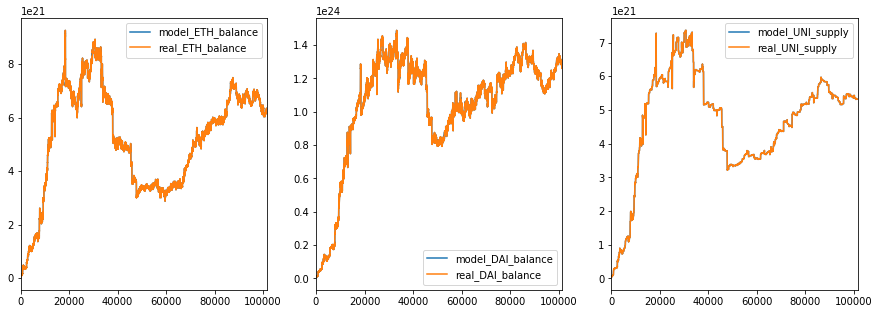

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
model_history.astype(float).plot(ax=ax, y=['model_ETH_balance'])
real_history.astype(float).plot(ax=ax, y=['real_ETH_balance'])
ax = plt.subplot(132)
model_history.astype(float).plot(ax=ax, y=['model_DAI_balance'])
real_history.astype(float).plot(ax=ax, y=['real_DAI_balance'])
ax = plt.subplot(133)
model_history.astype(float).plot(ax=ax, y=['model_UNI_supply'])
real_history.astype(float).plot(ax=ax, y=['real_UNI_supply'])

Only if we look much more closely can we see some deviation

In [19]:
model_history.tail(1)

,model_DAI_balance,model_ETH_balance,model_UNI_supply
101484,1268445487370480899199906,6306058808358170889735,5320123300661846672003


In [20]:
real_history.tail(1)

,real_DAI_balance,real_ETH_balance,real_UNI_supply
101484,1268456444556868663822658,6306033015368245238058,5320135262833503868378


In [21]:
model_history.iloc[-1]['model_DAI_balance']/real_history.iloc[-1]['real_DAI_balance']

0.9999913617953263

In [22]:
model_history.iloc[-1]['model_ETH_balance']/real_history.iloc[-1]['real_ETH_balance']

1.0000040902085134

In [23]:
model_history.iloc[-1]['model_UNI_supply']/real_history.iloc[-1]['real_UNI_supply']

0.9999977515286612

In [24]:
real_history = uniswap_events.iloc[1:][['block_timestamp','token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['timestamp','real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']
freq = 'D'
plot_title_format = '%Y-%b-%d %H:%M'
if freq == 'D':
    plot_title_format = '%Y-%b-%d'
plot_data = real_history.copy()
plot_data.columns = ['timestamp','DAI_balance','ETH_balance','UNI_supply']
plot_data[['DAI_balance','ETH_balance','UNI_supply']] = plot_data[['DAI_balance','ETH_balance','UNI_supply']]*1E-18
plot_data['ts_minute'] = plot_data['timestamp'].apply(lambda x: x.floor(freq))
plot_data = plot_data.drop_duplicates('ts_minute', keep='last')
plot_data.index = plot_data.ts_minute#,format='%Y-%m')
plot_data = plot_data.resample(freq).pad()
plot_data['ts_minute'] = plot_data.index
# plot_data['ts_minute'] = plot_data['ts_minute'].apply(lambda x: x.date())
plot_data = plot_data.drop('timestamp', axis='columns')
plot_data = plot_data.reset_index(drop=True)
plot_data['ETH_price_DAI'] = plot_data['DAI_balance'] / plot_data['ETH_balance']
plot_data['UNI_price_DAI'] = 2 * plot_data['DAI_balance'] / plot_data['UNI_supply']
plot_data['50_50_hodler_value'] = 0.5 * plot_data['ETH_price_DAI'][0] + 0.5 * plot_data['ETH_price_DAI']
plot_data['50_50_hodler_return'] = plot_data['50_50_hodler_value']/plot_data['50_50_hodler_value'][0] - 1
plot_data['UNI_hodler_return'] = plot_data['UNI_price_DAI']/plot_data['UNI_price_DAI'][0] - 1
plot_data['ETH_hodler_return'] = plot_data['ETH_price_DAI']/plot_data['ETH_price_DAI'][0] - 1
plot_data

,DAI_balance,ETH_balance,UNI_supply,ts_minute,ETH_price_DAI,UNI_price_DAI,50_50_hodler_value,50_50_hodler_return,UNI_hodler_return,ETH_hodler_return
0,5810.15,30.4969,30.0097,2018-11-02 00:00:00+00:00,190.516,387.219,190.516,0,0,0
1,5988.86,29.6193,30.0097,2018-11-03 00:00:00+00:00,202.195,399.129,196.356,0.0306502,0.0307579,0.0613005
2,6010.55,29.5135,30.0097,2018-11-04 00:00:00+00:00,203.654,400.574,197.085,0.0344792,0.0344901,0.0689583
3,6144.36,28.9117,30.0298,2018-11-05 00:00:00+00:00,212.521,409.217,201.519,0.0577507,0.0568101,0.115501
4,11322.7,53.8018,55.6061,2018-11-06 00:00:00+00:00,210.451,407.245,200.484,0.0523192,0.0517188,0.104638
...,...,...,...,...,...,...,...,...,...,...
321,1.33713e+06,6051.31,5354.83,2019-09-19 00:00:00+00:00,220.965,499.409,205.741,0.0799114,0.289734,0.159823
322,1.31479e+06,6063.89,5314.48,2019-09-20 00:00:00+00:00,216.823,494.795,203.669,0.0690403,0.277818,0.138081
323,1.30814e+06,6095.48,5314.24,2019-09-21 00:00:00+00:00,214.608,492.315,202.562,0.0632288,0.271413,0.126458
324,1.29778e+06,6166.66,5322.89,2019-09-22 00:00:00+00:00,210.451,487.622,200.484,0.0523184,0.259294,0.104637


In [25]:
# %%capture --no-display cell_capture
#avoid warnings in cell output

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='jshtml', embed_limit=50)
from matplotlib import cm
import matplotlib.ticker as ticker



fig, axs = plt.subplots(ncols=4, nrows=3,
                       figsize=(15,9),
                       gridspec_kw = {'hspace':0.4})

#grid setup
gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0:, 0:-1]:
    for i in ax:
        i.remove()
axbig = fig.add_subplot(gs[0:, 0:-1])
ax1 =  axs[0][3]
ax2 =  axs[1][3]
ax3 =  axs[2][3]

plt.close()
axbig_colors=cm.Paired.colors

xlim = float(max(plot_data['DAI_balance'])*1.3)
ylim = float(max(plot_data['ETH_balance'])*1.3)

ax1_ylim = max(plot_data['UNI_supply'])*1.1
ax2_ylim_t = max(max(plot_data['ETH_hodler_return']),max(plot_data['UNI_hodler_return']),max(plot_data['50_50_hodler_return']))*1.1
ax2_ylim_b = min(min(plot_data['ETH_hodler_return']),min(plot_data['UNI_hodler_return']),min(plot_data['50_50_hodler_return']))*1.1
ax3_ylim_t = 0
ax3_ylim_b = 0
for i in range(len(plot_data)):
    y1 = plot_data.iloc[i]['UNI_price_DAI'] / plot_data.iloc[:i+1]['UNI_price_DAI'].astype(float)
    y2 = plot_data.iloc[i]['50_50_hodler_value'] / plot_data.iloc[:i+1]['50_50_hodler_value'].astype(float)
#     y1 = y1 ** (365/(i+1)) #for annualized returns
#     y2 = y2 ** (365/(i+1))
    y = y1/y2-1
    ax3_ylim_t = max(ax3_ylim_t,max(y))
    ax3_ylim_b = min(ax3_ylim_b,min(y))
ax3_ylim_t = ax3_ylim_t * 1.1
ax3_ylim_b = ax3_ylim_b * 1.1

In [29]:
def animate(i):
    axbig.clear()
    ax1.clear()
    ax2.clear()
    ax3.clear()
    a = plot_data.iloc[i]['DAI_balance']
    b = plot_data.iloc[i]['ETH_balance']
    k = a * b
    x = np.arange(a*0.05, xlim+a*0.05, a*0.05)
    y = k / x
    axbig.plot(x,y,color=axbig_colors[0])
    axbig.plot(float(a),float(b),color=axbig_colors[1],marker='o')
    axbig.fill([0,0,float(a),float(a)],
            [0,float(b),float(b),0],
            color=axbig_colors[2])
    axbig.plot([0,float(a)],[0,float(b)],color=axbig_colors[3])
    axbig.set_xlim(left=0, right=xlim)
    axbig.set_ylim(bottom=0, top=ylim)
    axbig.set_xticks(ticks=[float(a), xlim])
    axbig.set_yticks(ticks=[float(b), ylim])
    axbig.set_xlabel('DAI')
    axbig.set_ylabel('ETH', labelpad=-12)
    axbig.set_title('ETH and DAI balances')
    axbig.legend(['bonding curve', 
               'current balance', 
               'A*B = k = {:.2E}'.format(k)],
             loc=2)
    labels = axbig.xaxis.get_ticklabels()
    labels[1].set_horizontalalignment('right')
    
    plot_data.iloc[:i+1]['UNI_supply'].astype(float).plot(ax=ax1)
    ax1.set_xlim(left=0, right=len(plot_data))
    ax1.set_ylim(bottom=0, top=ax1_ylim)
    ax1.set_xticks(ticks=[])
#     ax1.set_xticklabels([plot_data['ts_minute'][i].strftime('%m/%d/%Y')])
    ax1.set_yticks(ticks=[float(plot_data.iloc[i]['UNI_supply']), ax1_ylim])
    ax1.set_title('UNI supply')
    ax1.yaxis.tick_right()

    ax2.axhline(0, color='gainsboro')
    plot_data.iloc[:i+1]['UNI_hodler_return'].astype(float).plot(ax=ax2, label='Liq. Provider')
    plot_data.iloc[:i+1]['50_50_hodler_return'].astype(float).plot(ax=ax2, label='50/50 hodler')
    plot_data.iloc[:i+1]['ETH_hodler_return'].astype(float).plot(ax=ax2, label='ETH hodler')
    ax2.set_xticks(ticks=[i])
    ax2.set_xticklabels([plot_data['ts_minute'][i].strftime('%b-%d')])
    ax2.set_xlim(left=0, right=len(plot_data))
    ax2.set_ylim(ax2_ylim_b,ax2_ylim_t)
    ax2.set_yticks([float(plot_data.iloc[i]['50_50_hodler_return']), 
                   float(plot_data.iloc[i]['UNI_hodler_return']),
                   float(plot_data.iloc[i]['ETH_hodler_return'])])
    ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    ax2.yaxis.tick_right()
    ax2.legend(loc='upper left')
    ax2.set_title('Strategy Returns')


    y1 = plot_data.iloc[i]['UNI_price_DAI'] / plot_data.iloc[:i+1]['UNI_price_DAI'].astype(float)
    y2 = plot_data.iloc[i]['50_50_hodler_value'] / plot_data.iloc[:i+1]['50_50_hodler_value'].astype(float)
#     y1 = y1 ** (365/(i+1)) ## for annualized returns
#     y2 = y2 ** (365/(i+1))
    y = y1/y2-1
    x = plot_data.iloc[:i+1]['ts_minute'].apply(lambda x: x.strftime('%b-%d'))
    ax3.bar(x=x, height=y)
    ax3.set_xlim(left=0, right=len(plot_data))
    ax3.set_ylim(ax3_ylim_b,ax3_ylim_t)
    ax3.yaxis.tick_right()
    ax3.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax3.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    ax3.set_title('Liq. Provider vs. 50/50 hodler \n from Day-0 to {}'.format(
        plot_data['ts_minute'][i].strftime('%b-%d')
    ))
    ax3.xaxis.set_label_text('Day-0')
    ax3.grid()



    fig.suptitle('Uniswap ETH-DAI, {}'.format(
        plot_data['ts_minute'][i].strftime(plot_title_format)
    ))    

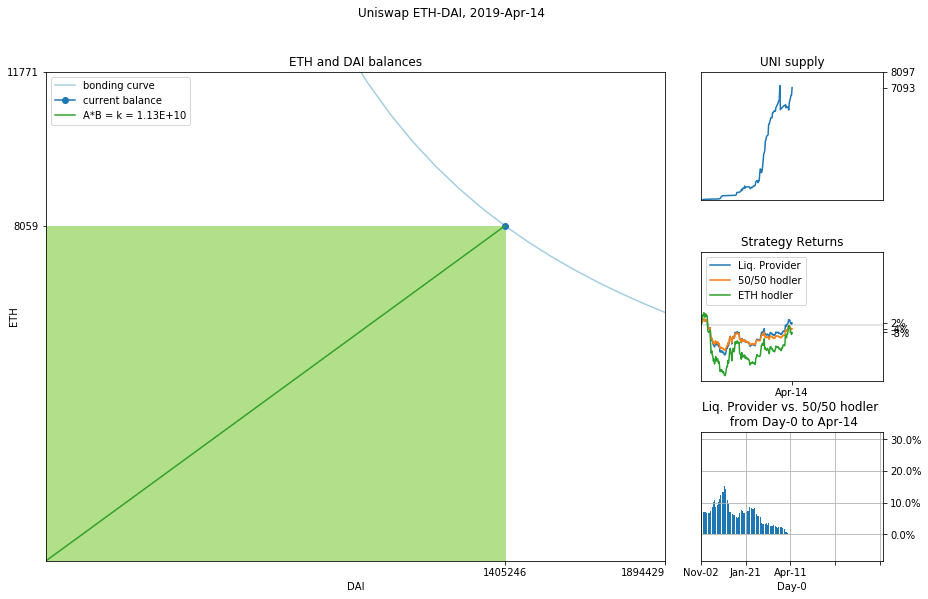

In [30]:
animate(len(plot_data)//2)
fig

In [ ]:
# anim = animation.FuncAnimation(fig, animate, np.arange(0, 500), interval=1)
anim = animation.FuncAnimation(fig, animate, np.arange(0, len(plot_data)), interval=100)

In [ ]:
%%capture --no-display cell_capture 
#avoid warnings in cell output

anim.save('uniswap.mp4')

In [ ]:
%%time
HTML(anim.to_jshtml())

In [ ]:
i = 10
y1 = plot_data.iloc[i]['UNI_price_DAI'] / plot_data.iloc[:i+1]['UNI_price_DAI'].astype(float)
y2 = plot_data.iloc[i]['50_50_hodler_value'] / plot_data.iloc[:i+1]['50_50_hodler_value'].astype(float)

In [ ]:
pd.DataFrame(y1).dot(y1.transpose())

In [ ]:
df = pd.DataFrame({'a' : [4,1,3], 'b' : [5,2,4]},index=[1,2,3])
print(df)
s = pd.Series([0.6,0.4],index=['a','b'])
print(s)
df.dot(s)

In [ ]:
a = pd.DataFrame(columns=y1.index)
a

In [ ]:
y1.transpose()

In [ ]:
list(y1)

In [ ]:
pd.DataFrame(y1)

In [ ]:
y1

In [ ]:
a = pd.DataFrame(y1).dot(pd.DataFrame(1/y1).transpose())
a

In [ ]:
a = a.where(np.triu(np.ones(a.shape)).astype(np.bool))
a

In [ ]:
b = pd.DataFrame(y2).dot(pd.DataFrame(1/y2).transpose())
b = b.where(np.triu(np.ones(b.shape)).astype(np.bool))
b

In [ ]:
uni = plot_data['UNI_price_DAI']
uni.index = uni.values
uni

In [ ]:
pd.DataFrame(uni).dot(pd.DataFrame(1/uni).transpose())